In [65]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy as sp
from scipy.constants import speed_of_light as c

import seaborn as sns

import colorcet as cc
import matplotlib.colors as colors
from matplotlib import gridspec

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.feature import LAND
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import scipy.stats as stats
from scipy.interpolate import splrep, splev


import sys
sys.path.append('modules')
import cs_module as cs
import absorption_module as am
import cloud_module as cm

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

# I like serif fonts
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams['text.usetex'] = False
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [66]:
from importlib import reload
reload(cs)
reload(am)
reload(cm)

<module 'cloud_module' from '/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py'>

### Fig. 1
$T_s - T_{cld}$, relative humidity, CRE, and spectral fluxes from example columns.

In [3]:
# load in xshield mean variables and example line-by-line calculations
xshield_mean = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/xshield_mean_for_fig1.nc')
ex_cells = xr.open_dataset("/data/pc2943/spectral-clouds-paper-figures/data/example_cell_spec_high_low.nc")

In [4]:
# indeces of example cells
cells = np.array([[np.where((xshield_mean.colRH < 31) & (xshield_mean.Ts - xshield_mean.tcloud > 16))[0][0]], # low RH, medium T_s - T_{cld}
                 [np.where((xshield_mean.colRH > 70) & (xshield_mean.Ts - xshield_mean.tcloud < 17))[0][2]], # high RH, medium T_s - T_{cld}
                 np.where((xshield_mean.colRH < 54) & (xshield_mean.Ts - xshield_mean.tcloud > 66.9))[0], # medium RH, high T_s - T_{cld}
                 [np.where((xshield_mean.colRH > 50) & (xshield_mean.Ts - xshield_mean.tcloud < 4))[0][0]]]).T[0] # medium RH, low T_s - T_{cld}


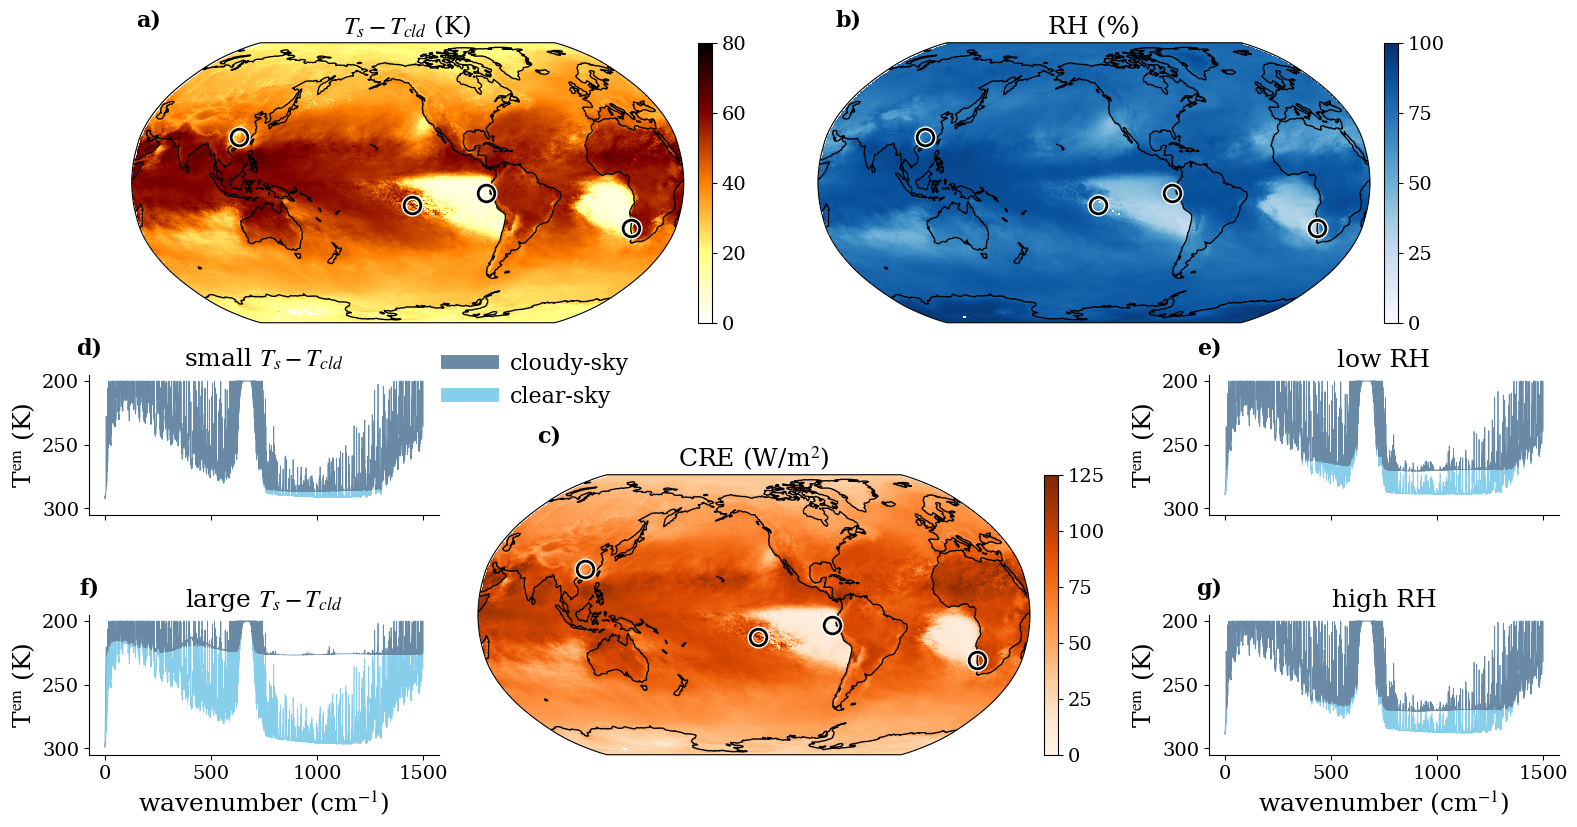

In [5]:
### plot figure

as_color = '#6a89a5'
cs_color = '#87CEEB' #'#0e6ba8'


fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

### Ts - Tcld
proj = ccrs.PlateCarree(central_longitude=-135)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=-135))
ax2.set_global()
ax2.coastlines()
hpshow = egh.healpix_show(xshield_mean.Ts - xshield_mean.tcloud, ax=ax2, cmap = 'afmhot_r', vmin=0, vmax=80)
cbar = plt.colorbar(hpshow, ax=ax2, pad=0.02, shrink=1, ticks = [0, 20, 40, 60, 80])

# mark example cells
ax2.plot(xshield_mean.lon[cells], xshield_mean.lat[cells], 'o', color = 'None', markersize = 12, markeredgecolor = 'white', markeredgewidth = 4, transform=ccrs.PlateCarree())
ax2.plot(xshield_mean.lon[cells], xshield_mean.lat[cells], 'o', color = 'None', markersize = 12, markeredgecolor = 'black', markeredgewidth = 2, transform=ccrs.PlateCarree())

ax2.set_title("$T_s - T_{cld}$ (K)")

### RH
bbox = ax2.get_position()
ax3 = fig.add_axes([0.47, bbox.y0, 0.35, bbox.height], projection=ccrs.Robinson(central_longitude=-135))
ax3.set_global()
ax3.coastlines()
ax3.plot(xshield_mean.lon[cells], xshield_mean.lat[cells], 'o', color = 'None', markersize = 12, markeredgecolor = 'white', markeredgewidth = 4, transform=ccrs.PlateCarree())
ax3.plot(xshield_mean.lon[cells], xshield_mean.lat[cells], 'o', color = 'None', markersize = 12, markeredgecolor = 'black', markeredgewidth = 2, transform=ccrs.PlateCarree())

hpshow = egh.healpix_show(xshield_mean.colRH, ax=ax3, cmap = 'Blues', vmin=0, vmax=100)
cbar = plt.colorbar(hpshow, ax=ax3, pad=0.02, shrink=1, ticks = [0, 25, 50, 75, 100])
ax3.set_title("RH (%)")

## CRE
ax0 = fig.add_axes([0.3, -0.01, 0.35, bbox.height], projection=ccrs.Robinson(central_longitude=-135))
ax0.set_global()
ax0.coastlines()
ax0.plot(xshield_mean.lon[cells], xshield_mean.lat[cells], 'o', color = 'None', markersize = 12, markeredgecolor = 'white', markeredgewidth = 4, transform=ccrs.PlateCarree())
ax0.plot(xshield_mean.lon[cells], xshield_mean.lat[cells], 'o', color = 'None', markersize = 12, markeredgecolor = 'black', markeredgewidth = 2, transform=ccrs.PlateCarree())

hpshow = egh.healpix_show(xshield_mean.cre, ax=ax0, cmap="Oranges", vmin=0, vmax=125)
cbar = plt.colorbar(hpshow, ax=ax0, pad=0.02, shrink=1, ticks = [0, 25, 50, 75, 100, 125])
ax0.set_title("CRE (W/m$^2$)")

### add spectral plots
# plot brightness temperature

## large T_s - T_cld
ax4 = fig.add_axes([0.12, -0.01, 0.35/2, bbox.height/2])
ax4.set_ylim([305, 195])
ax4.plot(ex_cells.nu, am.BT(ex_cells.cs_spec_up[2, -1, :]*c*100, ex_cells.nu.data), color = cs_color, linewidth = 0.5)
ax4.plot(ex_cells.nu, am.BT(ex_cells.as_spec_up[2, -1, :]*c*100, ex_cells.nu.data), color = as_color, linewidth = 0.5)
ax4.set_ylabel("T$^{\\mathrm{em}}$ (K)")
ax4.set_xlabel("wavenumber (cm$^{-1}$)")
ax4.set_title('large $T_s - T_{cld}$')

## small T_s - T_cld
ax5 = fig.add_axes([0.12, 0.29, 0.35/2, bbox.height/2], sharey = ax4)
ax5.plot(ex_cells.nu, am.BT(ex_cells.cs_spec_up[3, -1, :]*c*100, ex_cells.nu.data), color = cs_color, linewidth = 0.5)
ax5.plot(ex_cells.nu, am.BT(ex_cells.as_spec_up[3, -1, :]*c*100, ex_cells.nu.data), color = as_color, linewidth = 0.5)
ax5.set_ylabel("T$^{\\mathrm{em}}$ (K)")
ax5.set_xticklabels([])
ax5.set_title('small $T_s - T_{cld}$')
ax5.plot([], [], linewidth = 10, color = as_color, label = 'cloudy-sky')
ax5.plot([], [], linewidth = 10, color = cs_color, label = 'clear-sky')
ax5.legend(frameon = False, loc = (1, 0.7))

## high RH
ax6 = fig.add_axes([0.68, -0.01, 0.35/2, bbox.height/2], sharex = ax4, sharey = ax4)
ax6.plot(ex_cells.nu, am.BT(ex_cells.cs_spec_up[1, -1, :]*c*100, ex_cells.nu.data), color = cs_color, linewidth = 0.5)
ax6.plot(ex_cells.nu, am.BT(ex_cells.as_spec_up[1, -1, :]*c*100, ex_cells.nu.data), color = as_color, linewidth = 0.5)
ax6.set_xlabel("wavenumber (cm$^{-1}$)")
ax6.set_ylabel("T$^{\\mathrm{em}}$ (K)")
ax6.set_title('high RH')

## low RH
ax7 = fig.add_axes([0.68, 0.29, 0.35/2, bbox.height/2], sharey = ax4)
ax7.plot(ex_cells.nu, am.BT(ex_cells.cs_spec_up[0, -1, :]*c*100, ex_cells.nu.data), color = cs_color, linewidth = 0.5)
ax7.plot(ex_cells.nu, am.BT(ex_cells.as_spec_up[0, -1, :]*c*100, ex_cells.nu.data), color = as_color, linewidth = 0.5)

ax7.set_ylabel("T$^{\\mathrm{em}}$ (K)")
ax7.set_xticklabels([])
ax7.set_title("low RH")

sns.despine(ax = ax4)
sns.despine(ax = ax5)

sns.despine(ax = ax6)
sns.despine(ax = ax7)

fig.text(0.15, 0.9, 'a)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.5, 0.9, 'b)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.35, 0.38, 'c)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.12, 0.49, 'd)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.68, 0.49, 'e)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.12, 0.19, 'f)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.68, 0.19, 'g)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')

#plt.savefig("Figures/mean_and_spec_CRE.png", bbox_inches = 'tight', dpi = 700)

plt.show()


## Fig. 2
Line-by-line absorption coefficients, CRE model schematic

In [6]:
## load in line-by-line and idealized absorption coefficients at 100 hPa, 300 K
k = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/lbl_idealized_k.nc')

### cloudy-sky and clear-sky emission temperature (idealized)
TOA_as_model = cm.get_Trad_total_cloud(cs.nu, 310, 200, 250, cs.get_gammaLR(310, 200), 0.75, 420e-6, T0 = 300)
TOA_cs_model = cm.get_Trad_total_cloud(cs.nu, 310, 200, 310, cs.get_gammaLR(310, 200), 0.75, 420e-6, T0 = 300)

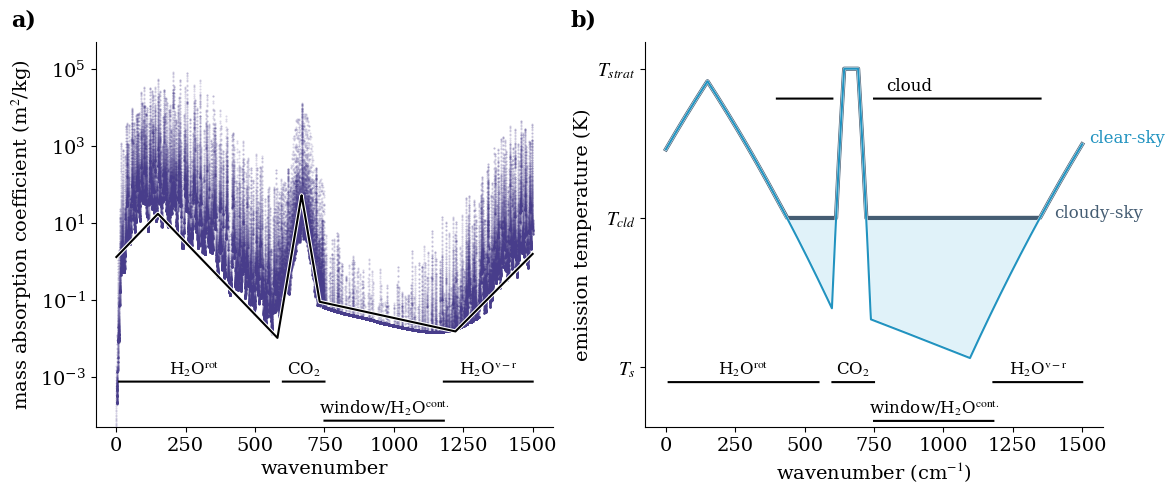

In [7]:
as_color = '#6a89a5'
cs_color = '#87CEEB' #'#0e6ba8'

fig, ax = plt.subplots(1, 2, figsize = (13, 5))

### absorption coefficients
# line-by-line data, calculated using ARTS
ax[0].plot(k.wavenumber, k.k_lbl.data, 'o', markersize = 0.5, alpha = 0.2, color = 'darkslateblue')

# model data, using functions in cs_module
ax[0].plot(k.nu, k.k_model.data, '-', color = 'white', linewidth = 3)
ax[0].plot(k.nu, k.k_model.data, '-', color = 'black', linewidth = 1.5)
ax[0].set_yscale('log')
ax[0].set_xlabel("wavenumber", fontsize = 14)
ax[0].set_ylabel("mass absorption coefficient (m$^2$/kg)", fontsize = 14)
ax[0].set_ylim([5*10**-5, 5*10**5])

### mark spectral bands
upper_coord = 2**10**(-2)
lower_coord = 7.5*10**(-4)
lowest_coord = 7.25*10**(-5)
wavenumber_coords = cs.nu
text_fontsize = 12
add = -4*10**(-4)
add_window = -4*10**(-5)

H2O_band_1 = wavenumber_coords[np.where((10 < wavenumber_coords) & (wavenumber_coords < 550))[0]]
ax[0].plot(H2O_band_1, lower_coord*np.ones(len(H2O_band_1)), color = 'black')
ax[0].text((10 + 550)/2, lower_coord - add, 'H$_2$O$^\\mathrm{rot}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

CO2_band = wavenumber_coords[np.where((600 < wavenumber_coords) & (wavenumber_coords < 750))[0]]
ax[0].plot(CO2_band, lower_coord*np.ones(len(CO2_band)), color = 'black')
ax[0].text((600 + 750)/2, lower_coord - add, 'CO$_2$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

window = wavenumber_coords[np.where(((750 < wavenumber_coords) &  (wavenumber_coords < 1180)))[0]]
ax[0].plot(window, lowest_coord*np.ones(len(window)), color = 'black')
ax[0].text((750 + 1180)/2, lowest_coord - add_window, 'window/H$_2$O$^\\mathrm{cont.}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

H2O_band_2 = wavenumber_coords[np.where(wavenumber_coords > 1180)[0]]
ax[0].plot(H2O_band_2, lower_coord*np.ones(len(H2O_band_2)), color = 'black')
ax[0].text((1180 + 1500)/2, lower_coord - add, 'H$_2$O$^\\mathrm{v-r}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)


### CRE
# fill in CRE area
ax[1].fill_between(cs.nu, TOA_as_model, TOA_cs_model, color = cs_color, alpha = 0.25)

# plot model OLR values
ax[1].plot(cs.nu, TOA_as_model, color = '#455D73', linewidth = 3)
ax[1].plot(cs.nu, TOA_cs_model, color = 'white', linewidth = 2)
ax[1].plot(cs.nu, TOA_cs_model, color = '#2193C0', linewidth = 1.5)
sns.despine()
ax[1].set_xlabel("wavenumber (cm$^{-1}$)", fontsize = 14)
ax[1].set_ylabel("emission temperature (K)", fontsize = 14)
ax[1].set_ylim([320, 191])

# labels
ax[1].set_yticks([200, 250, 300], labels = ['$T_{strat}$', '$T_{cld}$', '$T_s$'])
ax[1].text(1400, 250, 'cloudy-sky', color = '#455D73', horizontalalignment = 'left', fontsize = 12)
ax[1].text(1525, 225, 'clear-sky', color = '#2193C0', horizontalalignment = 'left', fontsize = 12)


### draw spectral labels
upper_coord = 210
lower_coord = 305
lowest_coord = 318
wavenumber_coords = cs.nu
text_fontsize = 12
add = 2.5

H2O_band_1 = wavenumber_coords[np.where((10 < wavenumber_coords) & (wavenumber_coords < 550))[0]]
ax[1].plot(H2O_band_1, lower_coord*np.ones(len(H2O_band_1)), color = 'black')
ax[1].text((10 + 550)/2, lower_coord - add, 'H$_2$O$^\\mathrm{rot}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

cloud1 = wavenumber_coords[np.where(((400 < wavenumber_coords) & (wavenumber_coords < 600)))[0]]
ax[1].plot(cloud1, upper_coord*np.ones(len(cloud1)), color = 'black')
ax[1].text((1350 + 400)/2, upper_coord - add, 'cloud', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

cloud2 = wavenumber_coords[np.where(((750 < wavenumber_coords) & (wavenumber_coords < 1350)))[0]]
ax[1].plot(cloud2, upper_coord*np.ones(len(cloud2)), color = 'black')

CO2_band = wavenumber_coords[np.where((600 < wavenumber_coords) & (wavenumber_coords < 750))[0]]
ax[1].plot(CO2_band, lower_coord*np.ones(len(CO2_band)), color = 'black')
ax[1].text((600 + 750)/2, lower_coord - add, 'CO$_2$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

window = wavenumber_coords[np.where(((750 < wavenumber_coords) &  (wavenumber_coords < 1180)))[0]]
ax[1].plot(window, lowest_coord*np.ones(len(window)), color = 'black')
ax[1].text((750 + 1180)/2, lowest_coord - add, 'window/H$_2$O$^\\mathrm{cont.}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

H2O_band_2 = wavenumber_coords[np.where(wavenumber_coords > 1180)[0]]
ax[1].plot(H2O_band_2, lower_coord*np.ones(len(H2O_band_2)), color = 'black')
ax[1].text((1180 + 1500)/2, lower_coord - add, 'H$_2$O$^\\mathrm{v-r}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)
ax[1].set_yticks([200, 250, 300], labels = ['$T_{strat}$', '$T_{cld}$', '$T_s$'])

fig.text(0.07, 0.91, 'a)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.5, 0.91, 'b)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')

#lt.savefig('Figures/schematic_spectral_CRE.png', dpi = 1000, bbox_inches = 'tight')
plt.show()

### Fig. 3
OLR in cloud top temperature; spectral model vs. $\sigma T^4$ blackbody assumption; inversion for cloud top temperature

In [8]:
# import data
LUT = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/model_CRE_gamma_edit_a3.nc')['__xarray_dataarray_variable__'].isel(qco2 = 0) # lookup table for inversion
ref_OLR = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/ref_olr_March_ds.nc') # OLR from X-SHiELD in March Snapshot
March_OLRs_da = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/OLR_snapshot_gamma_edit_a3.nc') # OLR from spectral model in X-SHiELD state
arts_clouds_spec = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/allsky_spectral_fluxes_validation_spectral.nc') # line-by-line cloudy-sky OLR

In [9]:
## find minimum brightness temperature in window region in 0% RH

cloud_idx = np.where((arts_clouds_spec.nu > 800) & (arts_clouds_spec.nu < 1200))[0]
CTT_min = np.zeros((len(arts_clouds_spec.colRH), len(arts_clouds_spec.CTT)))
for RH_idx in range(len(arts_clouds_spec.colRH)):
    for CTT_idx in range(len(arts_clouds_spec.CTT)):
        CTT_min[RH_idx, CTT_idx] = np.max(am.BT(arts_clouds_spec.as_spec_up[0, RH_idx, CTT_idx, -1, :]*c*100, arts_clouds_spec.nu)[cloud_idx])

CTT_min = (CTT_min[0, :][:, None]*np.ones(len(arts_clouds_spec.colRH))).T

In [10]:
### calculate model CRE, all-sky, and clear-sky OLR
model_CRE = np.zeros_like(CTT_min)
model_OLR_as = np.zeros_like(CTT_min)
model_OLR_cs = np.zeros_like(CTT_min)

for RH_idx in range(len(arts_clouds_spec.colRH)):
    for idx in range(len(arts_clouds_spec.CTT.data)):
        rh = arts_clouds_spec['colRH'].isel(colRH = RH_idx).data
        #tcloud = arts_clouds_spec['CTT'].isel(column = idx).data
        tcloud = CTT_min[RH_idx, idx]

        gamma_LR = cs.get_gammaLR(290, 200)
        Tem_as = cm.get_Trad_total_cloud(cs.nu, 290, 200, tcloud, gamma_LR, rh, cs.qco2)
        Tem_cs = cm.get_Trad_total_cloud(cs.nu, 290, 200, 290, gamma_LR, rh, cs.qco2)

        _, model_OLR_as[RH_idx, idx] = cs.OLR_from_Tem(cs.nu, Tem_as)
        _, model_OLR_cs[RH_idx, idx] = cs.OLR_from_Tem(cs.nu, Tem_cs)

        model_CRE[RH_idx, idx] = cm.calc_model_CRE(cs.nu, 290, tcloud, gamma_LR, rh, cs.qco2)

spectral_CTTs = np.zeros_like(CTT_min)
SB_CTTs = np.zeros_like(CTT_min)

ts_val = 290
for RH_idx in range(len(arts_clouds_spec.colRH)):
    for idx, column in enumerate(arts_clouds_spec.CTT):
        rh_val = arts_clouds_spec['colRH'].isel(colRH = RH_idx).data
        lut_profile = LUT.interp(rh=rh_val, ts=ts_val, gammaLR = cs.get_gammaLR(ts_val, 200))
        sorted_idx = np.argsort(lut_profile.values)
        cre_vals = lut_profile.values[sorted_idx]
        tcloud_vals = lut_profile['tcloud'].values[sorted_idx]

        if np.all(np.diff(cre_vals) >= 0):
            spectral_CTTs[RH_idx, idx] = np.interp(arts_clouds_spec.cs_up[0, RH_idx, idx, -1] - arts_clouds_spec.as_up[0, RH_idx, idx, -1], cre_vals, tcloud_vals)
            
        SB_CTTs[RH_idx, idx] = am.BT_from_OLR(arts_clouds_spec.as_up[0, RH_idx, idx, -1])


/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:128: RuntimeWarning: overflow encountered in scalar power
  term = (T_em/T0)**(2*gammaWV - a) * (rh**2 * tau_star)/((2*gammaWV - a)*gammaLR)
/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:128: RuntimeWarning: invalid value encountered in scalar multiply
  term = (T_em/T0)**(2*gammaWV - a) * (rh**2 * tau_star)/((2*gammaWV - a)*gammaLR)


/home/pc2943/miniforge3/envs/ddq_fluxsim_easy25/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


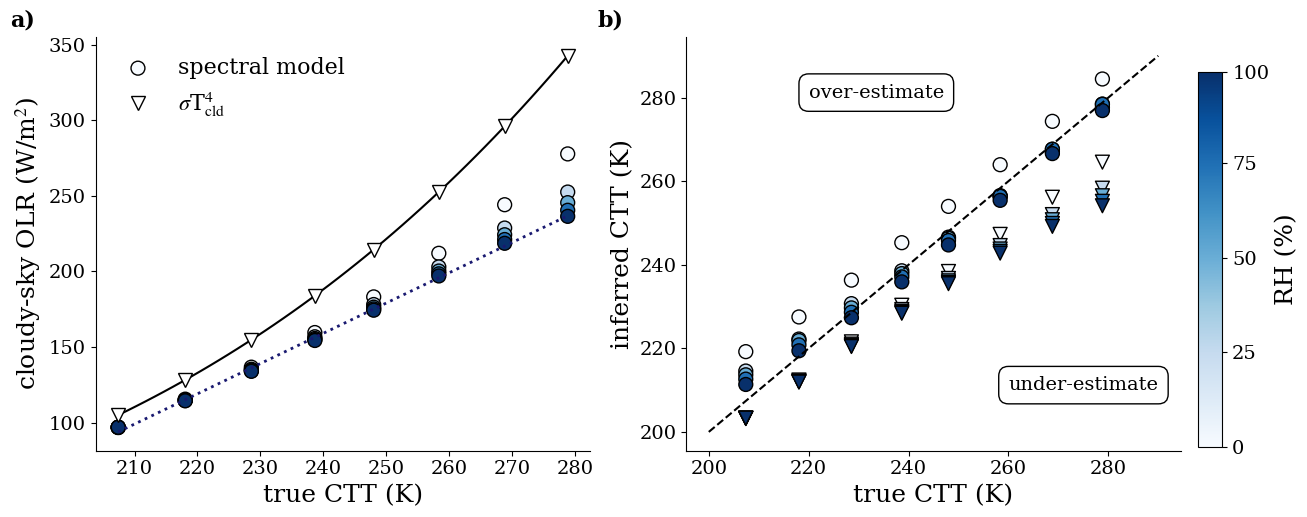

In [11]:
## plot
fig, axes = plt.subplots(1, 2, figsize = (12, 5), tight_layout=True)

ms = 100 # marker size

# fit line to OLR
slope, intercept = np.polyfit(CTT_min[-1, :], arts_clouds_spec.as_up[0, -1, :, -1].data, 1)
axes[0].plot(CTT_min[-1, :], slope*CTT_min[-1, :] + intercept, ':', color = 'midnightblue', label = '__nolabel__', linewidth = 2)
axes[0].plot(np.linspace(CTT_min[0, 0], CTT_min[0, -1]), am.SB_sigma*(np.linspace(CTT_min[0, 0], CTT_min[0, -1]))**4, label='__nolabel__', color = 'black')

scatter = axes[0].scatter(CTT_min, arts_clouds_spec.as_up[0, :, :, -1], marker = 'o', c = arts_clouds_spec["colRH"].data[:, None]*np.ones_like(model_CRE), cmap = 'Blues', label='spectral model', edgecolors = 'black', s = ms)
axes[0].plot(CTT_min[0, :], am.SB_sigma*(CTT_min[0, :])**4, marker = 'v', markerfacecolor = 'white', markersize = 10, markeredgecolor = 'black', label='$\\sigma$T$_\\mathrm{cld}^4$', linestyle = "None")
sns.despine()
#axes[0].plot([200, 290], np.zeros(len([200, 290])), 'k--')
axes[0].set_ylabel("cloudy-sky OLR (W/m$^2$)")
axes[0].set_xlabel("true CTT (K)")


axes[1].scatter(CTT_min, spectral_CTTs, marker = 'o', c = arts_clouds_spec["colRH"].data[:, None]*np.ones_like(model_CRE), cmap = 'Blues', label='spectral model', edgecolors = 'black', s = ms)
axes[1].scatter(CTT_min, SB_CTTs, marker = 'v', c = arts_clouds_spec["colRH"].data[:, None]*np.ones_like(model_CRE), cmap = 'Blues', label='$\\sigma$T$_\\mathrm{cld}^4$', edgecolors = 'black', s = ms)
sns.despine()
axes[1].set_xlabel('true CTT (K)')
axes[1].set_ylabel('inferred CTT (K)')
axes[1].plot([200, 290], [200, 290], 'k--')


# Colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.75])
cbar = fig.colorbar(scatter, cax = cbar_ax, ticks=[0.0000001, 0.25, 0.5, 0.75, 0.99])
cbar.set_label("RH (%)")
cbar.ax.set_yticklabels(['0', '25', '50', '75', '100'])
fig.text(0.02, 0.99, 'a)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.51, 0.99, 'b)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')

axes[1].text(220, 280, 'over-estimate', fontsize = 14, bbox={'facecolor': 'none', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
axes[1].text(260, 210, 'under-estimate', fontsize = 14, bbox={'facecolor': 'none', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
axes[0].legend(frameon = False, loc = 'upper left')

#plt.savefig('Figures/CTT_comparison.png', bbox_inches='tight', dpi=300)
plt.show()


### Fig. 4
CREs from spectral model and X-SHiELD at given RH, CTT values

In [26]:
### open binned CRE data
olr_cre_binned = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/cre_rebinned_10deg_a3.nc')

# ignore negative values as unphysical
model_CRE = olr_cre_binned.model_CRE.where(olr_cre_binned.model_CRE > 0).values

# set parameter names
rh_array = olr_cre_binned.rh.values
Ts_array = olr_cre_binned.Ts.values
Tcloud_array = olr_cre_binned.Tcloud.values

In [30]:
rh_array = np.array([10**(-10), 0.25, 0.5, 0.75, 1]) #np.linspace(10e-10, 0.99, 100)
Ts_array = np.arange(205, 320, 10)
Tcloud_array = np.arange(185, 320, 10)
qco2_array = np.array([420])*1e-6

ideal_CRE = np.zeros((len(rh_array), len(Ts_array), len(Tcloud_array)))

for rh_idx, col_RH in enumerate(rh_array):
    for Ts_idx, T_s in enumerate(Ts_array):
        for Tcloud_idx, T_cloud in enumerate(Tcloud_array):
                
                gamma_LR = cs.get_gammaLR(T_s, 200)
                T_cloud = np.min([T_s, T_cloud])
                ideal_CRE[rh_idx, Ts_idx, Tcloud_idx] = cm.calc_model_CRE(cs.nu, T_s, T_cloud, gamma_LR, col_RH, 420e-6)
                
                if (T_cloud >= T_s) or (ideal_CRE[rh_idx, Ts_idx, Tcloud_idx] < 0):
                    ideal_CRE[rh_idx, Ts_idx, Tcloud_idx] = np.nan

/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:128: RuntimeWarning: overflow encountered in scalar power
  term = (T_em/T0)**(2*gammaWV - a) * (rh**2 * tau_star)/((2*gammaWV - a)*gammaLR)
/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:128: RuntimeWarning: invalid value encountered in scalar multiply
  term = (T_em/T0)**(2*gammaWV - a) * (rh**2 * tau_star)/((2*gammaWV - a)*gammaLR)


In [31]:
# linear regression

# find T_s - T_cld across all parameters
dT = np.empty((len(rh_array), len(Ts_array), len(Tcloud_array)))
for idx, Tcloud in enumerate(Tcloud_array):
    for idx_rh, rh in enumerate(rh_array):
              
        dT[idx_rh, :, idx] = Ts_array - Tcloud

# mask out values that are not present in both the idealized model and X-SHiELD
mask = ~np.isnan(model_CRE) & ~np.isnan(ideal_CRE)

# fit linear regression
m_ideal, b_ideal = np.polyfit(dT[mask], ideal_CRE[mask], 1)  
m_model, b_model = np.polyfit(dT[mask], model_CRE[mask], 1)  

/tmp/ipykernel_2904446/512171610.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


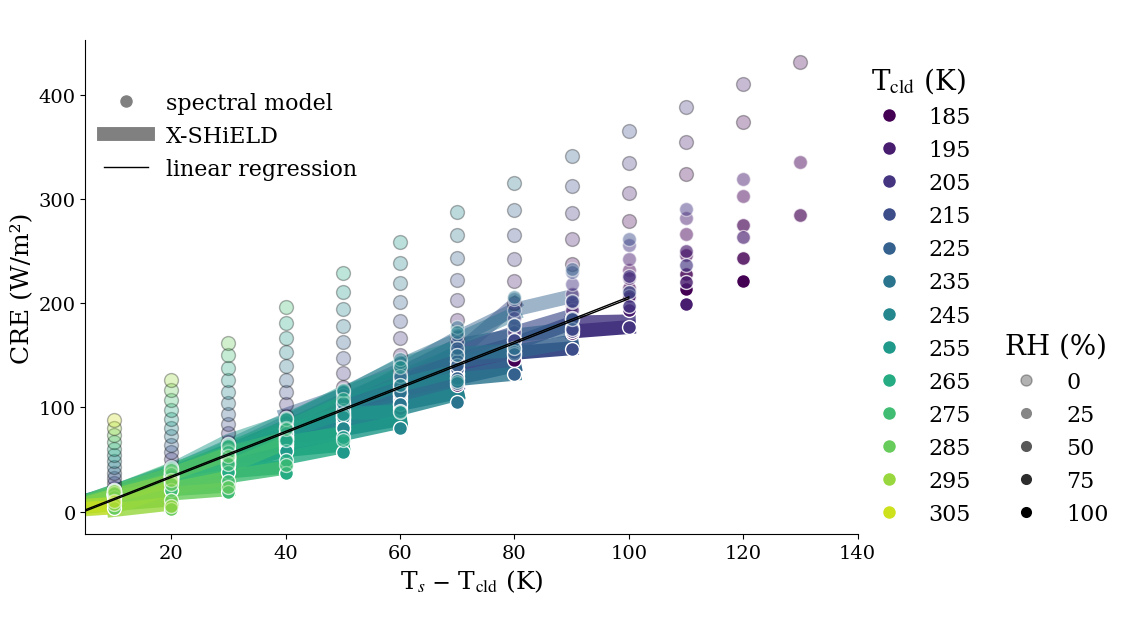

In [37]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex = True, sharey = True)

colors = plt.cm.viridis(np.linspace(0, 1, len(Tcloud_array)))

### plot X-SHiELD data
for idx, Tcloud in enumerate(Tcloud_array):
    for idx_rh, rh in enumerate(rh_array):
        cre_vals = model_CRE[idx_rh, :, idx] 
        alpha = 0.3 + 0.7 * rh # set point transparency based on RH (range: 0.3-1.0)

        if np.all(np.isnan(cre_vals)):
            continue

        axes.plot(Ts_array - Tcloud, cre_vals, '-', color=colors[idx], markerfacecolor = 'None', alpha = alpha, linewidth = 10)

### plot spectral model data
for idx, Tcloud in enumerate(Tcloud_array):
    for idx_rh, rh in enumerate(rh_array):
        cre_vals = ideal_CRE[idx_rh, :, (idx)] 
        alpha = 0.3 + 0.7 * rh  # range: 0.3–1.0
      
        if np.all(np.isnan(cre_vals)):
            continue

        if idx_rh == 0:
            axes.plot(Ts_array - Tcloud, cre_vals, 'o', color=colors[(idx)], alpha=alpha, markeredgecolor = 'black', markeredgewidth = 1, markersize = 10)
            axes.plot([], [], 'o', label=f'{Tcloud:.0f}', color=colors[(idx)], alpha=1, markeredgecolor = 'white', markeredgewidth = 1, markersize = 10)                

        else:
            axes.plot(Ts_array - Tcloud, cre_vals, 'o', color=colors[(idx)], alpha=alpha, markeredgecolor = 'white', markeredgewidth = 1, markersize = 10)


sns.despine()
axes.set_xlabel('T$_s$ $-$ T$_\\mathrm{cld}$ (K)')
axes.set_ylabel('CRE (W/m²)')
axes.set_xlim([5, 140])

# plot linear regressions
x = np.linspace(5, 100)
axes.plot(x, m_ideal*(x) + b_ideal, color = 'black', linewidth = 1)
axes.plot(x, m_model*(x) + b_model, color = 'black', linewidth = 1)

axes.legend(title='T$_\\mathrm{cld}$ (K)', frameon=False, title_fontsize=20, loc=(1, 0.0))

# add axes for legend
rh_legend_ax = fig.add_axes([1, 0, 0.1, 1])
for idx_rh, rh in enumerate(rh_array):
    alpha = 0.3 + 0.7 * rh  # range: 0.3–1.0
    if idx_rh == 0:
        rh_legend_ax.plot([], [], 'o', color = 'black', alpha = alpha, label = f'{rh*100:.0f}', markersize = 8, markeredgecolor = 'black')
    else:
        rh_legend_ax.plot([], [], 'o', color = 'black', alpha = alpha, label = f'{rh*100:.0f}', markersize = 8, markeredgecolor = 'None')

rh_legend_ax.legend(title='RH (%)', frameon=False, title_fontsize=20, loc=(0, 0.125))
rh_legend_ax.axis('off')
sns.despine()

marker_legend_ax = fig.add_axes([1, 0, 0.1, 1])
marker_legend_ax.plot([], [], 'o', color = 'grey', label = 'spectral model', markersize = 10, markeredgecolor = 'white', markeredgewidth = 1)
marker_legend_ax.plot([], [], '-', color = 'grey', label = 'X-SHiELD', linewidth = 10)
marker_legend_ax.plot([], [], color = 'black', label = 'linear regression', linewidth = 1)
marker_legend_ax.legend(frameon=False, loc=(-9, 0.7))
marker_legend_ax.axis('off')

plt.tight_layout()

#plt.savefig('Figures/deltaT_oneplt.png', dpi = 300, bbox_inches = 'tight')

plt.show()


### Fig. 5
Feedback schematic

In [40]:
### calculate emission temperatures for feedback schematic

# all-sky, before and after warming
TOA_as_model_pre = cm.get_Trad_total_cloud(cs.nu, 300, 200, 250, cs.get_gammaLR(300, 200), 0.75, 420e-6, T0 = 300)
TOA_as_model_post = cm.get_Trad_total_cloud(cs.nu, 310, 200, 251, cs.get_gammaLR(310, 200), 0.75, 420e-6, T0 = 300)

# clear-sky, before and after warming
TOA_cs_model_pre = cm.get_Trad_total_cloud(cs.nu, 300, 200, 300, cs.get_gammaLR(300, 200), 0.75, 420e-6, T0 = 300)
TOA_cs_model_post = cm.get_Trad_total_cloud(cs.nu, 310, 200, 310, cs.get_gammaLR(310, 200), 0.75, 420e-6, T0 = 300)

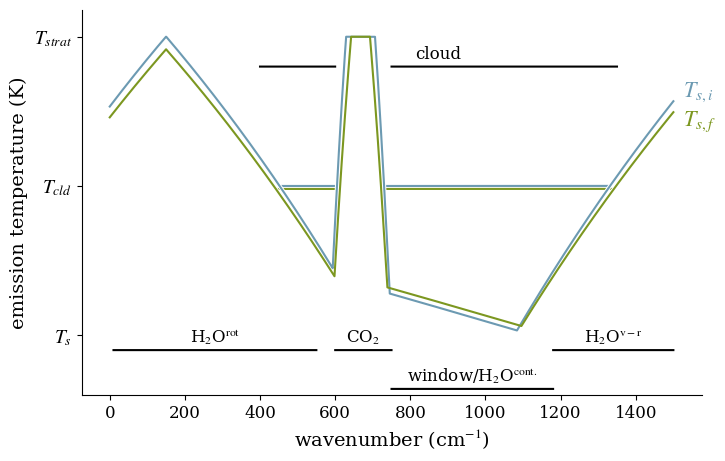

In [41]:
### make plot
cool_color = '#6C9AB2'
warm_color = '#B6D846'
warm_dark = '#7C9720'

fig, ax = plt.subplots(figsize = (8, 5))

plt.plot(cs.nu, TOA_as_model_pre, color = 'white', linewidth = 3)
plt.plot(cs.nu, TOA_as_model_post, color = 'white', linewidth = 3)
plt.plot(cs.nu, TOA_as_model_pre, color = cool_color, linewidth = 1.5)
plt.plot(cs.nu, TOA_as_model_post, color = warm_dark, linewidth = 1.5)

plt.plot(cs.nu, TOA_cs_model_pre, color = 'white', linewidth = 3)
plt.plot(cs.nu, TOA_cs_model_post, color = 'white', linewidth = 3)
plt.plot(cs.nu, TOA_cs_model_pre, color = cool_color, linewidth = 1.5)
plt.plot(cs.nu, TOA_cs_model_post, color = warm_dark, linewidth = 1.5)

sns.despine()
plt.xlabel("wavenumber (cm$^{-1}$)", fontsize = 14)
plt.ylabel("emission temperature (K)", fontsize = 14)
plt.ylim([270, 191])

plt.ylim([320, 191])


### draw spectral labels
upper_coord = 210
lower_coord = 305
lowest_coord = 318
wavenumber_coords = cs.nu
text_fontsize = 12
add = 2.5

H2O_band_1 = wavenumber_coords[np.where((10 < wavenumber_coords) & (wavenumber_coords < 550))[0]]
plt.plot(H2O_band_1, lower_coord*np.ones(len(H2O_band_1)), color = 'black')
plt.text((10 + 550)/2, lower_coord - add, 'H$_2$O$^\\mathrm{rot}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

cloud1 = wavenumber_coords[np.where(((400 < wavenumber_coords) & (wavenumber_coords < 600)))[0]]
plt.plot(cloud1, upper_coord*np.ones(len(cloud1)), color = 'black')
plt.text((1350 + 400)/2, upper_coord - add, 'cloud', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

cloud2 = wavenumber_coords[np.where(((750 < wavenumber_coords) & (wavenumber_coords < 1350)))[0]]
plt.plot(cloud2, upper_coord*np.ones(len(cloud2)), color = 'black')

CO2_band = wavenumber_coords[np.where((600 < wavenumber_coords) & (wavenumber_coords < 750))[0]]
plt.plot(CO2_band, lower_coord*np.ones(len(CO2_band)), color = 'black')
plt.text((600 + 750)/2, lower_coord - add, 'CO$_2$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

window = wavenumber_coords[np.where(((750 < wavenumber_coords) &  (wavenumber_coords < 1180)))[0]]
plt.plot(window, lowest_coord*np.ones(len(window)), color = 'black')
plt.text((750 + 1180)/2, lowest_coord - add, 'window/H$_2$O$^\\mathrm{cont.}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)

H2O_band_2 = wavenumber_coords[np.where(wavenumber_coords > 1180)[0]]
plt.plot(H2O_band_2, lower_coord*np.ones(len(H2O_band_2)), color = 'black')
plt.text((1180 + 1500)/2, lower_coord - add, 'H$_2$O$^\\mathrm{v-r}$', color = 'black', horizontalalignment = 'center', fontsize = text_fontsize)
plt.yticks([200, 250, 300], labels = ['$T_{strat}$', '$T_{cld}$', '$T_s$'])


### legends and labels
plt.plot([], [], '-', color = 'black', label = 'model')
plt.plot([], [], 'o', color = 'black', markersize = 3, label = 'LBL')

plt.text(1525, 220, '$T_{s, i}$', color = cool_color, horizontalalignment = 'left', fontsize = 16)
plt.text(1525, 230, '$T_{s, f}$', color = warm_dark, horizontalalignment = 'left', fontsize = 16)

plt.xticks(fontsize = 12)

plt.savefig('Figures/schematic_spectral_feedbacks.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Fig. 6
Fixed-cloud top temperature feedbacks

In [67]:
Ts_array = np.arange(205, 315, 5)
RH_array = np.array([0, 0.25, 0.5, 0.75, 0.99])
CTT_array = np.array([205, 215, 225, 235, 245, 255, 265, 275, 285, 295, 305])

analytical_feedbacks = np.full((len(RH_array), len(Ts_array), len(CTT_array)), np.nan)

for Ts_idx in range(len(Ts_array)):
    for RH_idx in range(len(RH_array)):
        for CTT_idx in range(len(CTT_array)):
            if Ts_array[Ts_idx] > CTT_array[CTT_idx]:
                analytical_feedbacks[RH_idx, Ts_idx, CTT_idx] = (cm.get_lambda_h2o(cs.nu, Ts_array[Ts_idx], 200, 
                                                    CTT_array[CTT_idx],
                                                    RH_array[RH_idx], cs.qco2, T0 = 300,
                                                    gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200),
                                                    dgammaLRdTs=None) 
                                                    + cm.get_lambda_cntm(cs.nu, Ts_array[Ts_idx], 200, 
                                                    CTT_array[CTT_idx],
                                                    RH_array[RH_idx], cs.qco2, T0 = 300,
                                                    gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200),
                                                    dgammaLRdTs=None)
                                                    + cm.get_lambda_co2(Ts_array[Ts_idx], 200, 
                                                    CTT_array[CTT_idx], cs.qco2,
                                                    gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200),
                                                    dgammaLRdTs=None))

/tmp/ipykernel_2904446/3599192141.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  analytical_feedbacks[RH_idx, Ts_idx, CTT_idx] = (cm.get_lambda_h2o(cs.nu, Ts_array[Ts_idx], 200,


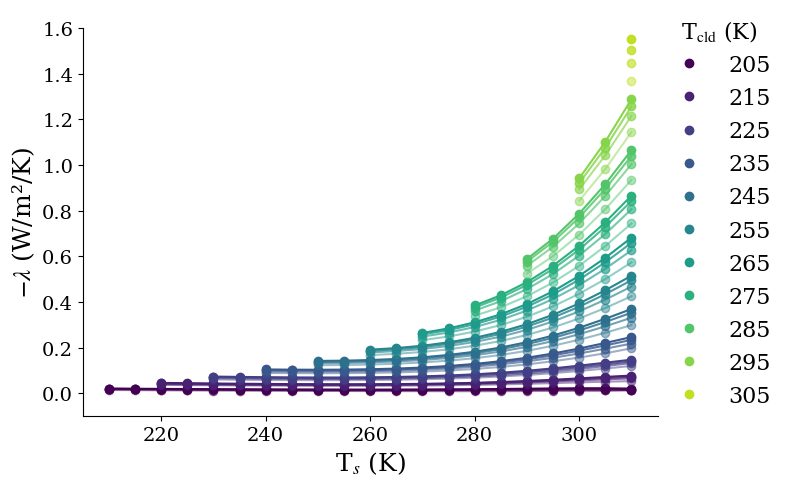

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

colors = plt.cm.viridis(np.linspace(0, 1, len(CTT_array) + 1))

fig, ax = plt.subplots(figsize=(8, 5))

# Plot for each selected cloud temperature
for idx, Tcloud in enumerate(CTT_array):  # Reverse the order
    for idx_rh, rh in enumerate(RH_array):
        af = analytical_feedbacks[idx_rh, :, idx]  # Note the negative index
        # Set alpha to be proportional to RH but with minimum visibility
        alpha = 0.3 + 0.7 * rh  # This gives alpha range of 0.3-1.0
        if Tcloud == 225:
            color_220 = colors[idx]
        elif Tcloud == 255:
            color_250 = colors[idx]
        elif Tcloud == 285:
            color_280 = colors[idx]
        if idx_rh == 4:
            ax.plot(Ts_array, af, '-o', label=f'{Tcloud}', color=colors[idx], alpha=alpha)
        else:
            ax.plot(Ts_array, af, '-o', color=colors[idx], alpha=alpha)



#ax_bottom.set_xticks([270, 280, 290, 300, 310])
ax.set_ylim([-0.1, 1.6])
ax.set_xlabel('T$_s$ (K)')
ax.set_ylabel('$-\\lambda$ (W/m²/K)')
#ax_bottom.legend(title='T$_\\mathrm{cld}$ (K)', frameon=False, title_fontsize=16, loc=(1, 0.0))

from matplotlib.legend_handler import HandlerLine2D

def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_marker("o")
    handle.set_linestyle('None')

ax.legend(title='T$_\\mathrm{cld}$ (K)', frameon=False, title_fontsize=16, loc=(1, 0), 
               handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})

sns.despine(ax=ax)

plt.tight_layout()
fig.savefig('Figures/fixed-t_feedbacks.png', dpi = 300, bbox_inches = 'tight')

plt.show()


### Fig. 7
Feedbacks with fixed-pressure clouds

In [71]:
Ts_array = np.arange(205, 315, 5)
RH_array = np.array([0, 0.25, 0.5, 0.75, 0.99])
CTT_array = np.array([205, 215, 225, 235, 245, 255, 265, 275, 285, 295, 305])

cloudt_feedback_gamma = np.full((len(RH_array), len(Ts_array), len(CTT_array)), np.nan)
dTclddTs = np.full((len(RH_array), len(Ts_array), len(CTT_array)), np.nan)
cs_gas = np.full((len(RH_array), len(Ts_array)), np.nan)
cs_sfc = np.full((len(RH_array), len(Ts_array)), np.nan)

for Ts_idx in range(len(Ts_array)):
    for RH_idx in range(len(RH_array)):
        for CTT_idx in range(len(CTT_array)):
            if Ts_array[Ts_idx] > CTT_array[CTT_idx]:
                cloudt_feedback_gamma[RH_idx, Ts_idx, CTT_idx] = cm.get_lambda_cloud(cs.nu, Ts_array[Ts_idx], 200,
                                                                            CTT_array[CTT_idx],
                                                                            RH_array[RH_idx], cs.qco2, T0 = 300, gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200), dgammaLRdTs=None) 
                
                dTclddTs[RH_idx, Ts_idx, CTT_idx] = cm.dTclouddTs(Ts_array[Ts_idx], 200, CTT_array[CTT_idx],
                                                                gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200), dgammaLRdTs=None)
                
                cs_gas[RH_idx, Ts_idx] = (cm.get_lambda_h2o(cs.nu, Ts_array[Ts_idx], 200,
                                                    Ts_array[Ts_idx],
                                                    RH_array[RH_idx], cs.qco2, T0 = 300,
                                                    gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200),
                                                    dgammaLRdTs=None) 
                                                    + cm.get_lambda_cntm(cs.nu, Ts_array[Ts_idx], 200, 
                                                    Ts_array[Ts_idx],
                                                    RH_array[RH_idx], cs.qco2, T0 = 300,
                                                    gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200),
                                                    dgammaLRdTs=None)
                                                    + cm.get_lambda_co2(Ts_array[Ts_idx], 200, 
                                                    Ts_array[Ts_idx],
                                                    cs.qco2,
                                                    gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200),
                                                    dgammaLRdTs=None) )
                
                cs_sfc[RH_idx, Ts_idx] = cm.get_lambda_cloud(cs.nu, Ts_array[Ts_idx], 200, Ts_array[Ts_idx], RH_array[RH_idx], cs.qco2, T0 = 300, gammaLR = cs.get_gammaLR(Ts_array[Ts_idx], 200), dgammaLRdTs=None)


/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:73: RuntimeWarning: divide by zero encountered in log
  R = nu_0 + l*np.log(term)
/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:74: RuntimeWarning: divide by zero encountered in log
  L = nu_0 - l*np.log(term)
/tmp/ipykernel_2904446/2820788702.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cloudt_feedback_gamma[RH_idx, Ts_idx, CTT_idx] = cm.get_lambda_cloud(cs.nu, Ts_array[Ts_idx], 200,
/tmp/ipykernel_2904446/2820788702.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dTclddTs[RH_idx, Ts_idx, CTT_idx] = cm.dTclouddTs(Ts_array[Ts_idx], 200, CT

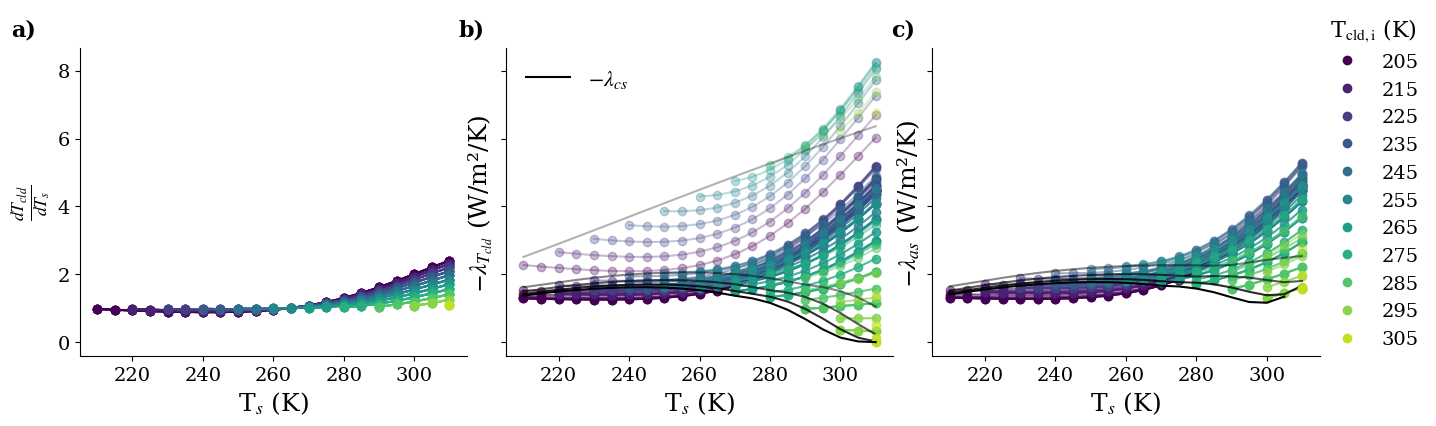

In [ ]:
### plot figure
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex = True, sharey = True)

colors = plt.cm.viridis(np.linspace(0, 1, len(CTT_array) + 1))

# Plot for each selected cloud temperature
for idx, Tcloud in enumerate(CTT_array): 
    for idx_rh, rh in enumerate(RH_array):
        # Set alpha to be proportional to RH but with minimum visibility
        alpha = 0.3 + 0.7 * rh  # This gives alpha range of 0.3-1.0

        # for legend
        if idx_rh == 4:
            axes[0].plot(Ts_array, dTclddTs[idx_rh, :, idx], '-o', label=f'{Tcloud}', color=colors[idx], alpha=alpha)
            axes[1].plot(Ts_array, cloudt_feedback_gamma[idx_rh, :, idx], '-o', color=colors[idx], alpha=alpha)
            l, = axes[2].plot(Ts_array, analytical_feedbacks[idx_rh, :, idx] + cloudt_feedback_gamma[idx_rh, :, idx], '-o', label=f'{Tcloud}', color=colors[idx], alpha=alpha)

        axes[0].plot(Ts_array, dTclddTs[idx_rh, :, idx], '-o', color=colors[idx], alpha=alpha)

        axes[1].plot(Ts_array, cloudt_feedback_gamma[idx_rh, :, idx], '-o', color=colors[idx], alpha=alpha)
        
        axes[2].plot(Ts_array, analytical_feedbacks[idx_rh, :, idx] + cloudt_feedback_gamma[idx_rh, :, idx], '-o', color=colors[idx], alpha=alpha)

        # clear-sky feedbacks
        if idx == 10:
            axes[1].plot(Ts_array, cs_sfc[idx_rh, :], '-', color='black', alpha=alpha)
            axes[2].plot(Ts_array, cs_gas[idx_rh, :] + cs_sfc[idx_rh, :], '-', color='black', alpha=alpha)

# axis labels
axes[0].set_ylabel('$\\frac{dT_{cld}}{dT_s}$')
axes[1].set_ylabel('$-\\lambda_{T_{cld}}$ (W/m²/K)')
axes[2].set_ylabel('$-\\lambda_{as}$ (W/m²/K)')
axes[0].set_xlabel('T$_s$ (K)')
axes[1].set_xlabel('T$_s$ (K)')
axes[2].set_xlabel('T$_s$ (K)')


### add temperature legend
from matplotlib.legend_handler import HandlerLine2D

def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_marker("o")
    handle.set_linestyle('None')

axes[2].legend(title='T$_\\mathrm{cld, i}$ (K)', frameon=False, title_fontsize=16, loc=(1, 0), fontsize = 14,
               handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
axes[1].plot([], [], label = '$-\\lambda_{cs}$', color = 'black')
axes[1].legend(frameon=False, fontsize = 16)

sns.despine()

# labels
fig.text(0.09, 0.91, 'a)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.37, 0.91, 'b)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.64, 0.91, 'c)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')

plt.subplots_adjust(wspace=0.1, hspace=0.15)
plt.savefig('Figures/cloudT_feedbacks.png', dpi = 300, bbox_inches = 'tight')
plt.show()


### B2
Validation of Spectral Model

In [74]:
# import data
LUT = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/model_CRE_gamma_edit_a3.nc')['__xarray_dataarray_variable__'].isel(qco2 = 0) # lookup table for inversion
ref_OLR = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/ref_olr_March_ds.nc') # OLR from X-SHiELD in March Snapshot
March_OLRs_da = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/OLR_snapshot_gamma_edit_a3.nc') # OLR from spectral model in X-SHiELD state
arts_clouds_spec = xr.open_dataset('/data/pc2943/spectral-clouds-paper-figures/data/allsky_spectral_fluxes_validation_spectral.nc') # line-by-line cloudy-sky OLR

In [76]:
## rerun Fig. 3 calculations
### calculate model CRE, all-sky, and clear-sky OLR
model_CRE = np.zeros_like(CTT_min)
model_OLR_as = np.zeros_like(CTT_min)
model_OLR_cs = np.zeros_like(CTT_min)

for RH_idx in range(len(arts_clouds_spec.colRH)):
    for idx in range(len(arts_clouds_spec.CTT.data)):
        rh = arts_clouds_spec['colRH'].isel(colRH = RH_idx).data
        #tcloud = arts_clouds_spec['CTT'].isel(column = idx).data
        tcloud = CTT_min[RH_idx, idx]

        gamma_LR = cs.get_gammaLR(290, 200)
        Tem_as = cm.get_Trad_total_cloud(cs.nu, 290, 200, tcloud, gamma_LR, rh, cs.qco2)
        Tem_cs = cm.get_Trad_total_cloud(cs.nu, 290, 200, 290, gamma_LR, rh, cs.qco2)

        _, model_OLR_as[RH_idx, idx] = cs.OLR_from_Tem(cs.nu, Tem_as)
        _, model_OLR_cs[RH_idx, idx] = cs.OLR_from_Tem(cs.nu, Tem_cs)

        model_CRE[RH_idx, idx] = cm.calc_model_CRE(cs.nu, 290, tcloud, gamma_LR, rh, cs.qco2)

spectral_CTTs = np.zeros_like(CTT_min)
SB_CTTs = np.zeros_like(CTT_min)

ts_val = 290
for RH_idx in range(len(arts_clouds_spec.colRH)):
    for idx, column in enumerate(arts_clouds_spec.CTT):
        rh_val = arts_clouds_spec['colRH'].isel(colRH = RH_idx).data
        lut_profile = LUT.interp(rh=rh_val, ts=ts_val, gammaLR = cs.get_gammaLR(ts_val, 200))
        sorted_idx = np.argsort(lut_profile.values)
        cre_vals = lut_profile.values[sorted_idx]
        tcloud_vals = lut_profile['tcloud'].values[sorted_idx]

        if np.all(np.diff(cre_vals) >= 0):
            spectral_CTTs[RH_idx, idx] = np.interp(arts_clouds_spec.cs_up[0, RH_idx, idx, -1] - arts_clouds_spec.as_up[0, RH_idx, idx, -1], cre_vals, tcloud_vals)
            
        SB_CTTs[RH_idx, idx] = am.BT_from_OLR(arts_clouds_spec.as_up[0, RH_idx, idx, -1])


/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:128: RuntimeWarning: overflow encountered in scalar power
  term = (T_em/T0)**(2*gammaWV - a) * (rh**2 * tau_star)/((2*gammaWV - a)*gammaLR)
/home/pc2943/spectral-clouds-paper-figures/modules/cloud_module.py:128: RuntimeWarning: invalid value encountered in scalar multiply
  term = (T_em/T0)**(2*gammaWV - a) * (rh**2 * tau_star)/((2*gammaWV - a)*gammaLR)


/tmp/ipykernel_2904446/3566061749.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figures/validation.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_2904446/3566061749.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figures/validation.png', bbox_inches='tight', dpi=300)
/home/pc2943/miniforge3/envs/ddq_fluxsim_easy25/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


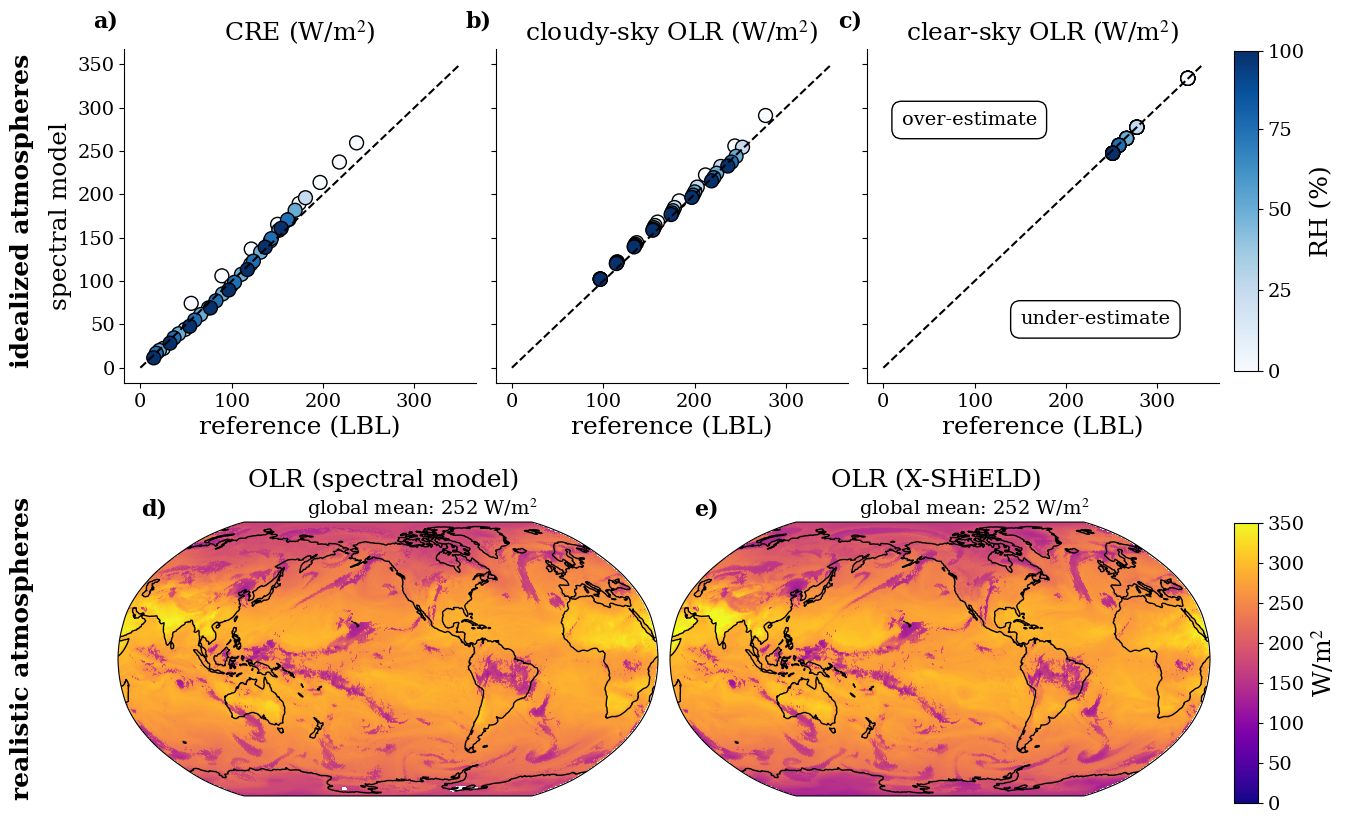

In [77]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8), tight_layout=True, sharey = True)

ms = 100

### test model CRE
sc1 = axes[0, 0].scatter(arts_clouds_spec.cs_up[0, :, :, -1] - arts_clouds_spec.as_up[0, :, :, -1], model_CRE, marker = 'o', c = arts_clouds_spec["colRH"].data[:, None]*np.ones_like(model_CRE), cmap = 'Blues', label='spectral CTT', edgecolors = 'black', s = ms)

sns.despine()
axes[0, 0].plot([0, 350], [0, 350], 'k--')
axes[0, 0].set_title('CRE (W/m$^2$)')
axes[0, 0].set_ylabel('spectral model')
axes[0, 0].set_xlabel('reference (LBL)')

### test allsky/cloudy column OLR
axes[0, 1].scatter(arts_clouds_spec.as_up[0, :, :, -1], model_OLR_as, marker = 'o', c = arts_clouds_spec["colRH"].data[:, None]*np.ones_like(model_CRE), cmap = 'Blues', label='spectral CTT', edgecolors = 'black', s = ms)
sns.despine()
axes[0, 1].set_xlabel('reference (LBL)')
axes[0, 1].plot([0, 350], [0, 350], 'k--')
axes[0, 1].set_title('cloudy-sky OLR (W/m$^2$)')

### test clear-sky OLR
sc2 = axes[0, 2].scatter(arts_clouds_spec.cs_up[0, :, :, -1], model_OLR_cs, marker = 'o', c = arts_clouds_spec["colRH"].data[:, None]*np.ones_like(model_CRE), cmap = 'Blues', label='spectral CTT', edgecolors = 'black', s = ms)
sns.despine()
axes[0, 2].set_xlabel('reference (LBL)')
axes[0, 2].plot([0, 350], [0, 350], 'k--')
axes[0, 2].set_title('clear-sky OLR (W/m$^2$)')

## add colorbar
cbar_ax = fig.add_axes([1, 0.54, 0.02, 0.4])
cbar2 = fig.colorbar(sc2, cax=cbar_ax, orientation='vertical', label='RH (%)', ticks=[0.0000001, 0.25, 0.5, 0.75, 0.99])
cbar2.ax.set_yticklabels(['0', '25', '50', '75', '100'])

axes[1, 0].axis('off')
axes[1, 1].axis('off')
axes[1, 2].axis('off')


### show OLR in X-SHiELD snapshot
# spectral model
ax0 = fig.add_axes([0.07, -0.07, 0.45, 0.5], projection = ccrs.Robinson(central_longitude = -135))
ax0.set_global()
ax0.coastlines()
hpshow = egh.healpix_show(March_OLRs_da.olr, ax = ax0, cmap = 'plasma', vmin = 0, vmax = 350)
ax0.set_title("OLR (spectral model) \n")

# X-SHiELD
ax1 = fig.add_axes([0.53, -0.07, 0.45, 0.5], projection = ccrs.Robinson(central_longitude = -135))
ax1.set_global()
ax1.coastlines()
hpshow = egh.healpix_show(ref_OLR.rlut, ax = ax1, cmap = 'plasma', vmin = 0, vmax = 350)
ax1.set_title("OLR (X-SHiELD) \n")

cbar_ax = fig.add_axes([1., -0.0, 0.02, 0.35])
cbar = fig.colorbar(hpshow, cax = cbar_ax)
cbar.set_label("W/m$^2$")

# labels
fig.text(0.42, 0.36, "global mean: %.0f" %(np.mean(March_OLRs_da.olr)) + " W/m$^2$", color = 'black', fontsize = 14, ha = 'right')
fig.text(0.88, 0.36, "global mean: %.0f" %(np.mean(ref_OLR.rlut)) + " W/m$^2$", color = 'black', fontsize = 14, ha = 'right')

fig.text(-0.02, 0.55, 'idealized atmospheres', rotation = 'vertical', fontsize = 18, weight = 'bold')
fig.text(-0.02, 0.01, 'realistic atmospheres', rotation = 'vertical', fontsize = 18, weight = 'bold')

fig.text(0.06, 0.97, 'a)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.37, 0.97, 'b)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.68, 0.97, 'c)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.1, 0.36, 'd)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig.text(0.56, 0.36, 'e)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')


axes[0, 2].text(20, 280, 'over-estimate', fontsize = 14, bbox={'facecolor': 'none', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
axes[0, 2].text(150, 50, 'under-estimate', fontsize = 14, bbox={'facecolor': 'none', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'})
plt.savefig('Figures/validation.png', bbox_inches='tight', dpi=300)

plt.show()

### Fig. C1
Validation of feedback models.

In [79]:
# load LBL data
dict = np.load('/data/pc2943/spectral-clouds-paper-figures/data/arts_clouds_for_lambda_interp_scale.npy', allow_pickle = True).item()
arts_clouds_xr = xr.Dataset(
    {
        "allsky_OLR": (["column"], np.stack(dict["array_of_irradiance_field_allsky"])[:, -1, 1]),
    },
    coords = {
        
        "column": dict["array_of_index"],
        "pressure": dict["array_of_pressure"][0],
    }
)

# only some combinations of Ts, CTT exist
Ts_array = np.arange(270, 310, 0.1)
colRH_array = np.array([0.75])
CTT_array = np.array([280, 250, 220])
CTT_array_min = np.array([CTT_min[3, -1], CTT_min[3, 4], CTT_min[3, 1]])
CTT_diff = CTT_array - CTT_array_min

T_s = []
CTTs = []
CTT_diffs = []
for colRH_idx, colRH in enumerate(colRH_array):
    for CTT_idx, CTT in enumerate(CTT_array):
        for Ts_idx, Ts in enumerate(Ts_array):
            if Ts > CTT:
                T_s.append(Ts)
                CTTs.append(CTT)
                CTT_diffs.append(CTT_diff[CTT_idx])

# convert to arrays with correct size
b1, b2 = 300, 700
new_Ts_0 = T_s[:b1]
new_Ts_1 = T_s[b1:b2]
new_Ts_2 = T_s[b2:]

new_OLR_0 = arts_clouds_xr.allsky_OLR[:b1]
new_OLR_1 = arts_clouds_xr.allsky_OLR[b1:b2]
new_OLR_2 = arts_clouds_xr.allsky_OLR[b2:]

h2o_feedback = np.empty((len(T_s)))
cntm_feedback = np.empty((len(T_s)))
co2_feedback = np.empty((len(T_s)))

# calculate idealized feedbacks
for idx in range(len(T_s)):
    h2o_feedback[idx] = cm.get_lambda_h2o(cs.nu, T_s[idx], 200, 
                                           CTTs[idx] - CTT_diffs[idx],
                                           0.75, cs.qco2, T0 = 300,
                                           gammaLR = cs.get_gammaLR(T_s[idx], 200),
                                           dgammaLRdTs=None)
    
    cntm_feedback[idx] = cm.get_lambda_cntm(cs.nu, T_s[idx], 200,
                                           CTTs[idx] - CTT_diffs[idx],
                                           0.75, cs.qco2, T0 = 300,
                                           gammaLR = cs.get_gammaLR(T_s[idx], 200),
                                           dgammaLRdTs=None)
    
    co2_feedback[idx] = cm.get_lambda_co2(T_s[idx], 200,
                                        CTTs[idx] - CTT_diffs[idx],
                                        cs.qco2,
                                        gammaLR = cs.get_gammaLR(T_s[idx], 200),
                                        dgammaLRdTs=None)
    

/tmp/ipykernel_2904446/1978709571.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2o_feedback[idx] = cm.get_lambda_h2o(cs.nu, T_s[idx], 200,
/tmp/ipykernel_2904446/1978709571.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cntm_feedback[idx] = cm.get_lambda_cntm(cs.nu, T_s[idx], 200,


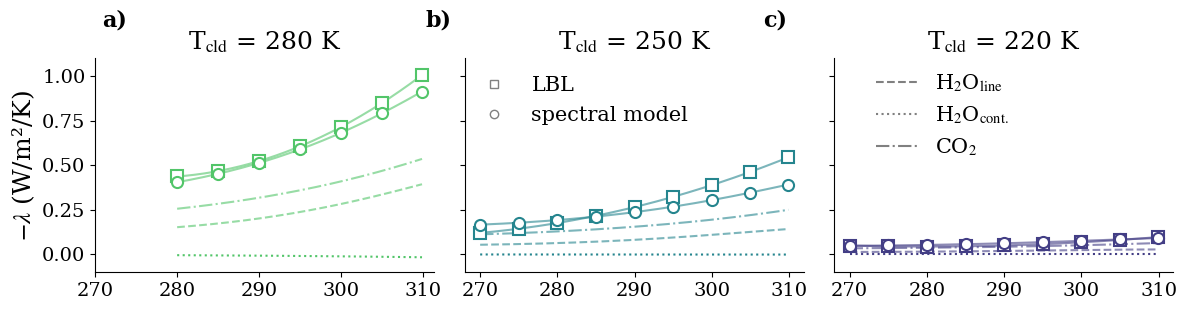

In [80]:
# create plot

from mpl_toolkits.axes_grid1 import make_axes_locatable

colors = plt.cm.viridis(np.linspace(0, 1, len(CTT_array) + 1))

fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3))

# CTT = 280 K
ax0.plot(new_Ts_0, h2o_feedback[:b1], color=color_280, linewidth=1.5, alpha=0.6, linestyle = '--')
ax0.plot(new_Ts_0, cntm_feedback[:b1], color=color_280, linewidth=1.5,  linestyle = 'dotted')
ax0.plot(new_Ts_0, co2_feedback[:b1], color=color_280, linewidth=1.5, alpha=0.6, linestyle = 'dashdot')

ax0.plot(new_Ts_0, splev(new_Ts_0, splrep(new_Ts_0, new_OLR_0, k=3, s=140), der=1), color=color_280, linewidth=1.5, alpha=0.6)
ax0.plot(new_Ts_0[::50], splev(new_Ts_0, splrep(new_Ts_0, new_OLR_0, k=3, s=140), der=1)[::50], color=color_280, marker='s', linestyle='None', markerfacecolor='white', markeredgecolor=color_280, markersize=8, mew=1.5)
ax0.plot(new_Ts_0[-1], splev(new_Ts_0, splrep(new_Ts_0, new_OLR_0, k=3, s=140), der=1)[-1], color=color_280, marker='s', linestyle='None', markerfacecolor='white', markeredgecolor=color_280, markersize=8, mew=1.5)

ax0.plot(new_Ts_0, h2o_feedback[:b1] + cntm_feedback[:b1] + co2_feedback[:b1], color=color_280, linewidth=1.5, alpha=0.6)
ax0.plot(new_Ts_0[::50], (h2o_feedback[:b1] + cntm_feedback[:b1] + co2_feedback[:b1])[::50], color=color_280, marker='o', linestyle='None', markerfacecolor='white', markeredgecolor=color_280, markersize=8, mew=1.5)
ax0.plot(new_Ts_0[-1], (h2o_feedback[:b1] + cntm_feedback[:b1] + co2_feedback[:b1])[-1], color=color_280, marker='o', linestyle='None', markerfacecolor='white', markeredgecolor=color_280, markersize=8, mew=1.5)

ax0.set_title('T$_\\mathrm{cld}$ = 280 K')
ax0.set_ylabel('$-\\lambda$ (W/m²/K)')
ax0.set_xticks([270, 280, 290, 300, 310])
ax0.set_ylim([-0.1, 1.1])

# CTT = 250 K
ax1.plot(new_Ts_1, h2o_feedback[b1:b2], color=color_250, linewidth=1.5, alpha=0.6, linestyle = '--')
ax1.plot(new_Ts_1, cntm_feedback[b1:b2], color=color_250, linewidth=1.5,  linestyle = 'dotted')
ax1.plot(new_Ts_1, co2_feedback[b1:b2], color=color_250, linewidth=1.5, alpha=0.6, linestyle = 'dashdot')

ax1.plot(new_Ts_1, splev(new_Ts_1, splrep(new_Ts_1, new_OLR_1, k=3, s=800), der=1), color=color_250, linewidth=1.5, alpha=0.6)
ax1.plot(new_Ts_1[::50], splev(new_Ts_1, splrep(new_Ts_1, new_OLR_1, k=3, s=800), der=1)[::50], color=color_250, marker='s', linestyle='None', markerfacecolor='white', markeredgecolor=color_250, markersize=8, mew=1.5)
ax1.plot(new_Ts_1[-1], splev(new_Ts_1, splrep(new_Ts_1, new_OLR_1, k=3, s=800), der=1)[-1], color=color_250, marker='s', linestyle='None', markerfacecolor='white', markeredgecolor=color_250, markersize=8, mew=1.5)

ax1.plot(new_Ts_1, h2o_feedback[b1:b2] + cntm_feedback[b1:b2] + co2_feedback[b1:b2], color=color_250, linewidth=1.5, alpha=0.6)
ax1.plot(new_Ts_1[::50], (h2o_feedback[b1:b2] + cntm_feedback[b1:b2] + co2_feedback[b1:b2])[::50], color=color_250, marker='o', linestyle='None', markerfacecolor='white', markeredgecolor=color_250, markersize=8, mew=1.5)
ax1.plot(new_Ts_1[-1], (h2o_feedback[b1:b2] + cntm_feedback[b1:b2] + co2_feedback[b1:b2])[-1], color=color_250, marker='o', linestyle='None', markerfacecolor='white', markeredgecolor=color_250, markersize=8, mew=1.5)


ax1.set_title('T$_\\mathrm{cld}$ = 250 K')
ax1.set_xticks([270, 280, 290, 300, 310])
ax1.set_ylim([-0.1, 1.1])
ax1.set_yticklabels([])

# CTT = 220 K
ax2.plot(new_Ts_2, h2o_feedback[b2:], color=color_220, linewidth=1.5, alpha=0.6, linestyle = '--')
ax2.plot(new_Ts_2, cntm_feedback[b2:], color=color_220, linewidth=1.5, linestyle = 'dotted')
ax2.plot(new_Ts_2, co2_feedback[b2:], color=color_220, linewidth=1.5, alpha=0.6, linestyle = 'dashdot')

ax2.plot(new_Ts_2, splev(new_Ts_2, splrep(new_Ts_2, new_OLR_2, k=3, s=800), der=1), color=color_220, linewidth=1.5, alpha=0.6)
ax2.plot(new_Ts_2[::50], splev(new_Ts_2, splrep(new_Ts_2, new_OLR_2, k=3, s=800), der=1)[::50], color=color_220, marker='s', linestyle='None', markerfacecolor='white', markeredgecolor=color_220, markersize=8, mew=1.5)
ax2.plot(new_Ts_2[-1], splev(new_Ts_2, splrep(new_Ts_2, new_OLR_2, k=3, s=800), der=1)[-1], color=color_220, marker='s', linestyle='None', markerfacecolor='white', markeredgecolor=color_220, markersize=8, mew=1.5)

ax2.plot(new_Ts_2, h2o_feedback[b2:] + cntm_feedback[b2:] + co2_feedback[b2:], color=color_220, linewidth=1.5, alpha=0.6)
ax2.plot(new_Ts_2[::50], (h2o_feedback[b2:] + cntm_feedback[b2:] + co2_feedback[b2:])[::50], color=color_220, marker='o', linestyle='None', markerfacecolor='white', markeredgecolor=color_220, markersize=8, mew=1.5)
ax2.plot(new_Ts_2[-1], (h2o_feedback[b2:] + cntm_feedback[b2:] + co2_feedback[b2:])[-1], color=color_220, marker='o', linestyle='None', markerfacecolor='white', markeredgecolor=color_220, markersize=8, mew=1.5)

ax2.set_title('T$_\\mathrm{cld}$ = 220 K')
ax2.set_xticks([270, 280, 290, 300, 310])
ax2.set_ylim([-0.1, 1.1])
ax2.set_yticklabels([])

sns.despine(ax=ax0)
sns.despine(ax = ax1)
sns.despine(ax = ax2)
ax1.plot([], [], 's', markerfacecolor = 'white', color='grey', label='LBL')
ax1.plot([], [], 'o', markerfacecolor = 'white', color='grey', label='spectral model')
ax1.legend(fontsize = 15, loc = (0.0, 0.65), frameon = False)

ax2.plot([], [], '--', color='grey', label='H$_2$O$_\\mathrm{line}$')
ax2.plot([], [], linestyle = 'dotted', color='grey', label='H$_2$O$_\\mathrm{cont.}$')
ax2.plot([], [],  linestyle = 'dashdot', color='grey', label='CO$_2$')
ax2.legend(fontsize = 15,  loc = (0.1, 0.495), frameon = False)

fig1.text(0.1, 0.96, 'a)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig1.text(0.37, 0.96, 'b)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')
fig1.text(0.65, 0.96, 'c)', color = 'black', horizontalalignment = 'center', fontsize = 16, weight = 'bold')

plt.tight_layout()
fig1.savefig('Figures/feedbacks_validation.png', dpi = 300, bbox_inches = 'tight')

plt.show()
